In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

/home/fikri/.virtualenvs/virtual-py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AttributeError: module 'keras.backend.tensorflow_backend' has no attribute '_get_available_gpus'

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 922948699215420057
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 92536832
locality {
  bus_id: 1
}
incarnation: 12834737183205714731
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 5888:00:00.0"
]


In [14]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [15]:
import keras
import types


print([getattr(keras.applications, a) for a in dir(keras.applications)
  if isinstance(getattr(keras.applications, a), types.FunctionType)])

[<function InceptionV3 at 0x7f74b566dea0>, <function MobileNet at 0x7f74b55f6400>, <function ResNet50 at 0x7f74b566dd08>, <function VGG16 at 0x7f74b595ed90>, <function VGG19 at 0x7f74b566dae8>, <function Xception at 0x7f74b55f60d0>]


In [1]:
image_size = 224
from keras.applications import MobileNet
#Load the VGG model
conv = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

/home/fikri/.virtualenvs/virtual-py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Freeze the layers except the last 4 layers
for layer in conv.layers:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in conv.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f4898075eb8> False
<keras.layers.convolutional.Conv2D object at 0x7f4898075fd0> False
<keras.layers.normalization.BatchNormalization object at 0x7f489808fe48> False
<keras.layers.core.Activation object at 0x7f4825cceb00> False
<keras.applications.mobilenet.DepthwiseConv2D object at 0x7f4825cce390> False
<keras.layers.normalization.BatchNormalization object at 0x7f4825c7f080> False
<keras.layers.core.Activation object at 0x7f4825c5ba90> False
<keras.layers.convolutional.Conv2D object at 0x7f4825bee748> False
<keras.layers.normalization.BatchNormalization object at 0x7f4825c13278> False
<keras.layers.core.Activation object at 0x7f4825bebbe0> False
<keras.applications.mobilenet.DepthwiseConv2D object at 0x7f4825bebcf8> False
<keras.layers.normalization.BatchNormalization object at 0x7f4825ba4208> False
<keras.layers.core.Activation object at 0x7f4825b0fac8> False
<keras.layers.convolutional.Conv2D object at 0x7f4825afaf98> False
<keras.layers

In [3]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(conv)
 
# Add new layers
# model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(75, activation='softmax'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(30, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                7710      
Total params: 16,081,886
Trainable params: 12,853,022
Non-trainable params: 3,228,864
_________________________________________________________________


In [4]:
train_dir = 'data/FIDS30/'
validation_dir = 'data/valid'

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 20
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 812 images belonging to 30 classes.
Found 159 images belonging to 30 classes.


In [9]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('MobileNet-False-FIDS30-Dense256.h5')

Epoch 1/50
9/8 [=================================] - 53s - loss: 2.3148 - acc: 0.4146 - val_loss: 1.7684 - val_acc: 0.6918
Epoch 2/50
9/8 [=================================] - 48s - loss: 2.2531 - acc: 0.4792 - val_loss: 1.7672 - val_acc: 0.6855
Epoch 3/50
9/8 [=================================] - 41s - loss: 1.9669 - acc: 0.5579 - val_loss: 1.5024 - val_acc: 0.7484
Epoch 4/50
9/8 [=================================] - 43s - loss: 1.9111 - acc: 0.5657 - val_loss: 1.4341 - val_acc: 0.7170
Epoch 5/50
9/8 [=================================] - 45s - loss: 1.9024 - acc: 0.5601 - val_loss: 1.3591 - val_acc: 0.8113
Epoch 6/50
9/8 [=================================] - 43s - loss: 1.7603 - acc: 0.6168 - val_loss: 1.3369 - val_acc: 0.7484
Epoch 7/50
9/8 [=================================] - 44s - loss: 1.7267 - acc: 0.6512 - val_loss: 1.1082 - val_acc: 0.7925
Epoch 8/50
9/8 [=================================] - 44s - loss: 1.6395 - acc: 0.6557 - val_loss: 1.1603 - val_acc: 0.8113
Epoch 9/50
9/8 [

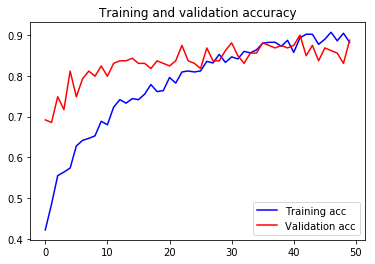

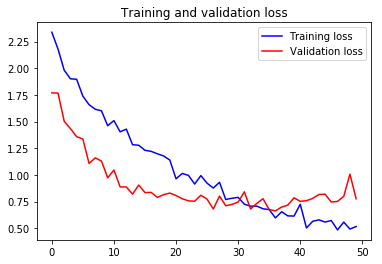

In [11]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [12]:
from keras.preprocessing.image import load_img
import numpy as np

# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
ground_truth
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
idx2label
# Get the predictions from the model using the generator
# predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
# predicted_classes = np.argmax(predictions,axis=1)
 
# errors = np.where(predicted_classes != ground_truth)[0]
# print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
# for i in range(len(errors)):
#     pred_class = np.argmax(predictions[errors[i]])
#     pred_label = idx2label[pred_class]
     
#     title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
#         fnames[errors[i]].split('/')[0],
#         pred_label,
#         predictions[errors[i]][pred_class])
     
#     original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
#     plt.figure(figsize=[7,7])
#     plt.axis('off')
#     plt.title(title)
#     plt.imshow(original)
#     plt.show()

Found 159 images belonging to 30 classes.


{0: 'acerolas',
 1: 'apples',
 2: 'apricots',
 3: 'avocados',
 4: 'bananas',
 5: 'blackberries',
 6: 'blueberries',
 7: 'cantaloupes',
 8: 'cherries',
 9: 'coconuts',
 10: 'figs',
 11: 'grapefruits',
 12: 'grapes',
 13: 'guava',
 14: 'kiwifruit',
 15: 'lemons',
 16: 'limes',
 17: 'mangos',
 18: 'olives',
 19: 'oranges',
 20: 'passionfruit',
 21: 'peaches',
 22: 'pears',
 23: 'pineapples',
 24: 'plums',
 25: 'pomegranates',
 26: 'raspberries',
 27: 'strawberries',
 28: 'tomatoes',
 29: 'watermelons'}